In [1]:
import pandas as pd
from rich.console import Console
console = Console()

In [2]:
preprocessed_data = pd.read_pickle("./pickled/creditcard_smotek.pkl")

In [3]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

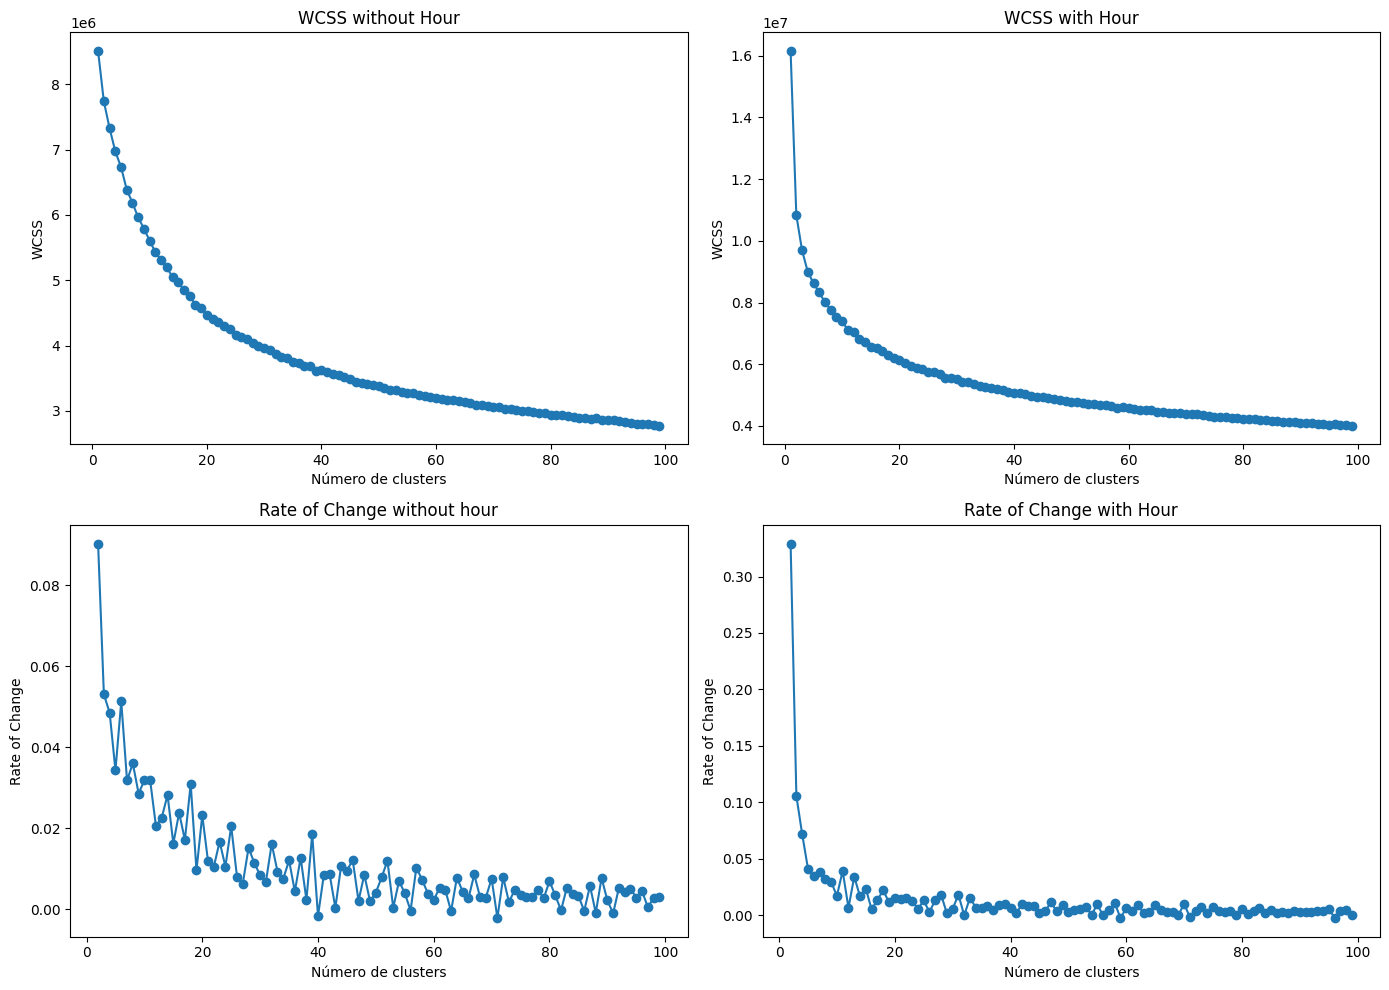

In [8]:
preprocessed_data_without_hour = preprocessed_data.drop(['Hour'], axis=1)

wcss = []
for i in range(1, 100):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0) 
    kmeans.fit(preprocessed_data)
    wcss.append(kmeans.inertia_)

wcss2 = []
for i in range(1, 100):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0) 
    kmeans.fit(preprocessed_data_without_hour)
    wcss2.append(kmeans.inertia_)

rateOfChange = []
for i in range(1, len(wcss)):
    roc = (wcss[i-1] - wcss[i]) / wcss[i-1]
    rateOfChange.append(roc)

rateOfChange2 = []
for i in range(1, len(wcss2)):
    roc = (wcss2[i-1] - wcss2[i]) / wcss2[i-1]
    rateOfChange2.append(roc)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

axes[0, 1].plot(range(1, 100), wcss, marker='o')
axes[0, 1].set_title('WCSS with Hour')
axes[0, 1].set_xlabel('Número de clusters')
axes[0, 1].set_ylabel('WCSS')

axes[0, 0].plot(range(1, 100), wcss2, marker='o')
axes[0, 0].set_title('WCSS without Hour')
axes[0, 0].set_xlabel('Número de clusters')
axes[0, 0].set_ylabel('WCSS')

axes[1, 1].plot(range(2, 100), rateOfChange, marker='o')
axes[1, 1].set_title('Rate of Change with Hour')
axes[1, 1].set_xlabel('Número de clusters')
axes[1, 1].set_ylabel('Rate of Change')

axes[1, 0].plot(range(2, 100), rateOfChange2, marker='o')
axes[1, 0].set_title('Rate of Change without hour')
axes[1, 0].set_xlabel('Número de clusters')
axes[1, 0].set_ylabel('Rate of Change')

plt.tight_layout()
plt.show()

#### k = 11 es el mejor y hay mucha diferencia en añadir hour

In [9]:
kmeans = KMeans(n_clusters=11, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(preprocessed_data)
preprocessed_data['cluster'] = kmeans.labels_

In [10]:
cluster_stats = preprocessed_data.groupby("cluster").agg({
    "Hour": ["mean", "min", "max"],
    "V1": ["mean", "min", "max"],
    "V2": ["mean", "min", "max"],
    "V3": ["mean", "min", "max"],
    "V4": ["mean", "min", "max"],
    "V5": ["mean", "min", "max"],
    "V6": ["mean", "min", "max"],
    "V7": ["mean", "min", "max"],
    "V8": ["mean", "min", "max"],
    "V9": ["mean", "min", "max"],
    "V10": ["mean", "min", "max"],
    "V11": ["mean", "min", "max"],
    "V12": ["mean", "min", "max"],
    "V13": ["mean", "min", "max"],
    "V14": ["mean", "min", "max"],
    "V15": ["mean", "min", "max"],
    "V16": ["mean", "min", "max"],
    "V17": ["mean", "min", "max"],
    "V18": ["mean", "min", "max"],
    "V19": ["mean", "min", "max"],
    "V20": ["mean", "min", "max"],
    "V21": ["mean", "min", "max"],
    "V22": ["mean", "min", "max"],
    "V23": ["mean", "min", "max"],
    "V24": ["mean", "min", "max"],
    "V25": ["mean", "min", "max"],
    "V26": ["mean", "min", "max"],
    "V27": ["mean", "min", "max"],
    "V28": ["mean", "min", "max"],
    "Amount": ["mean", "min", "max"],
    "Class": ["mean", "min", "max"],
})

#### Guardamos los datos de los clusters en una tabla separada

In [12]:
cluster_stats.columns = ["_".join(map(str, x)) for x in cluster_stats.columns.to_flat_index()]
cluster_stats.reset_index(inplace=True)
cluster_stats = cluster_stats.rename(columns={"cluster": "Cluster"})
cluster_stats.to_csv("./data/cluster_stats.csv", index=False)

#### Para visualizar los clusters se optó a usar diferentes mecanismos de visualización, a continuación se podrá ver cada uno de ellos

C:\Users\Rules\AppData\Local\Temp\ipykernel_23144\3715632997.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


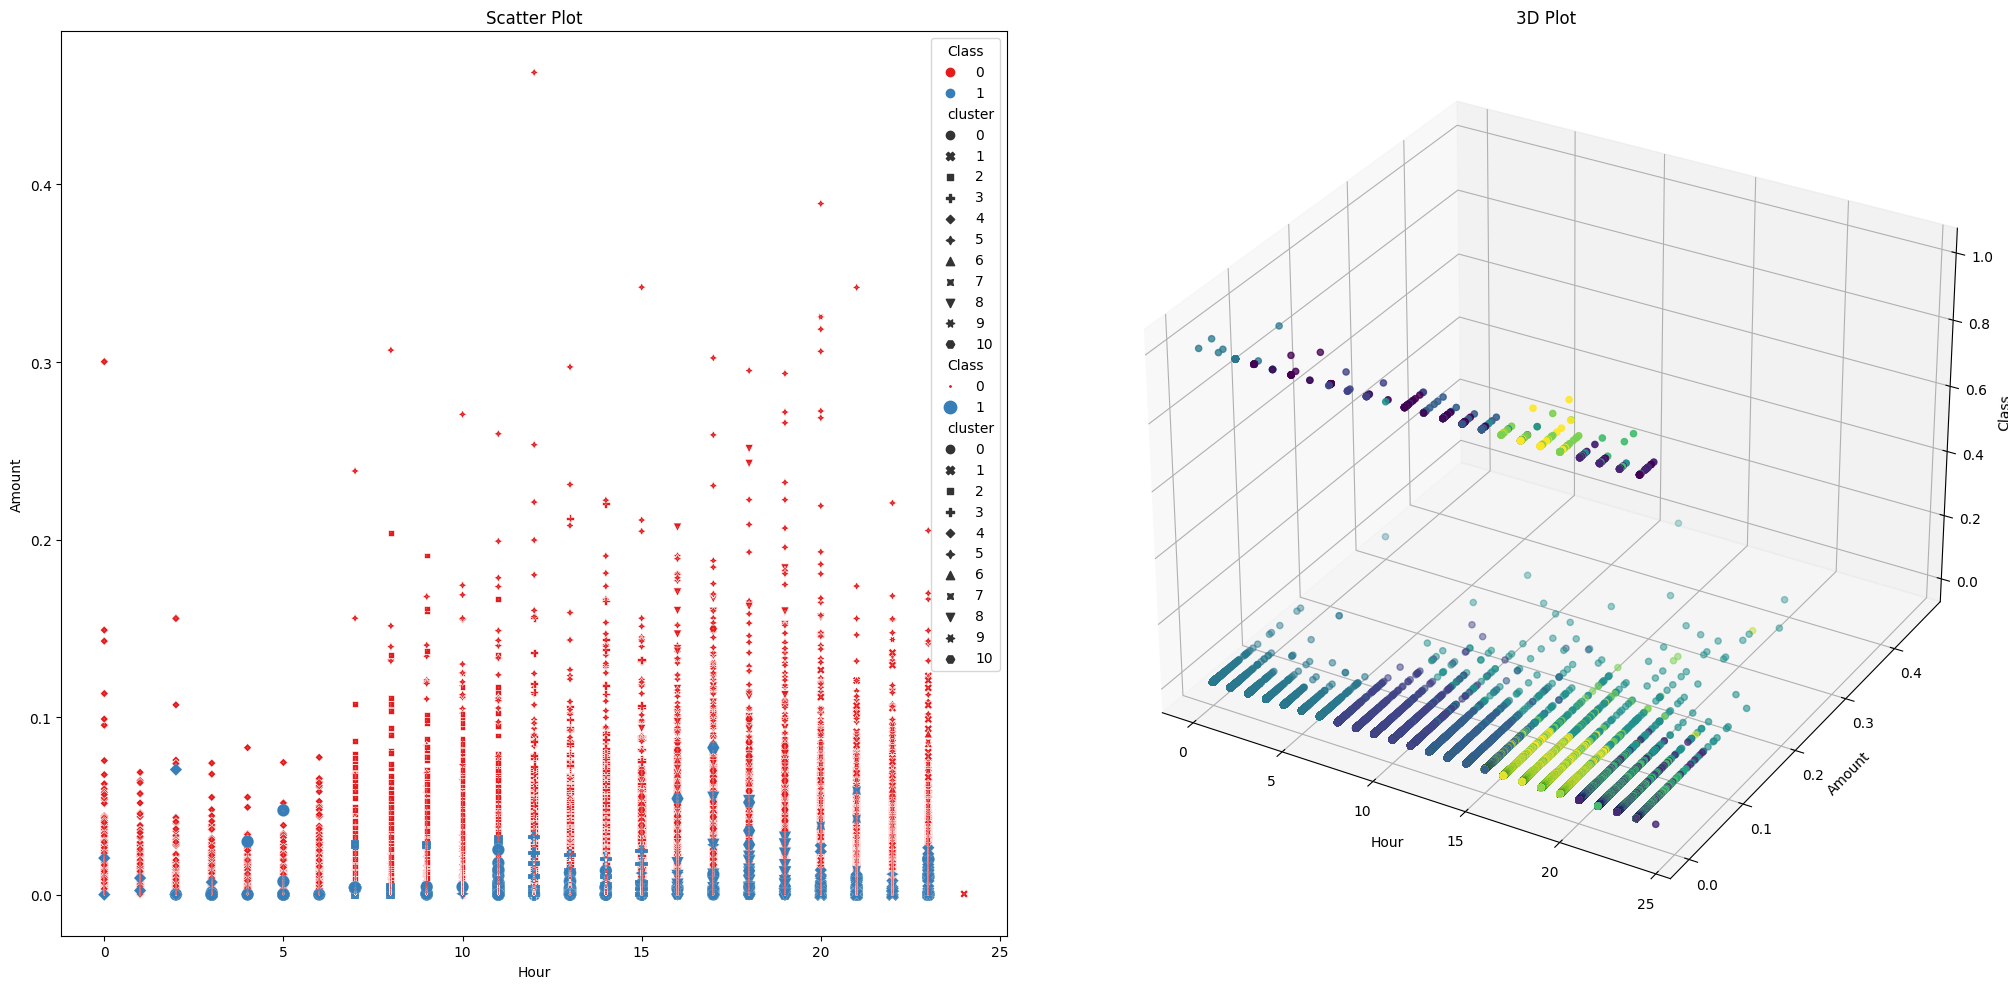

In [24]:
import seaborn as sns

fig = plt.figure(figsize=(30, 10))

# Gráfica 2: Scatter plot
ax2 = fig.add_subplot(132)
sns.scatterplot(x="Hour", y="Amount", hue="Class", style="cluster", data=preprocessed_data, palette="Set1", ax=ax2)
sns.scatterplot(x="Hour", y="Amount", hue="Class", style="cluster", size="Class", sizes=[1, 80], data=preprocessed_data, palette="Set1", ax=ax2)
ax2.set_title('Scatter Plot')

# Gráfica 3: Gráfico 3D
ax3 = fig.add_subplot(133, projection='3d')
x = preprocessed_data["Hour"]
TARGET = preprocessed_data["Amount"]
z = preprocessed_data["Class"]
c = preprocessed_data["cluster"]
ax3.scatter(x, TARGET, z, c=c)
ax3.set_xlabel("Hour")
ax3.set_ylabel("Amount")
ax3.set_zlabel("Class")
ax3.set_title('3D Plot')

plt.tight_layout()
plt.show()

Seguiremos con el apartado de agrupación jerárquica 

In [4]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np

Utilizaremos 3 tipos de agrupadores jerárquicos, single, centroid y ward. Se visualizará cada uno de ellos

In [5]:
duplicates = preprocessed_data.duplicated()
print(duplicates.sum())
preprocessed_data.drop_duplicates(inplace=True)
print(preprocessed_data.duplicated().sum())


3148
0


In [6]:
num_samples = 10000
start_index = 0

random_subset = preprocessed_data.sample(n=10000, random_state=42)

distanceMatrixSingle = linkage(random_subset, method='single')
distanceMatrixCentroid = linkage(random_subset, method='centroid')
distanceMatrixWard = linkage(random_subset, method='ward')

matrixes = {
    "Single": distanceMatrixSingle,
    "Centroid": distanceMatrixCentroid,
    "Ward": distanceMatrixWard
}

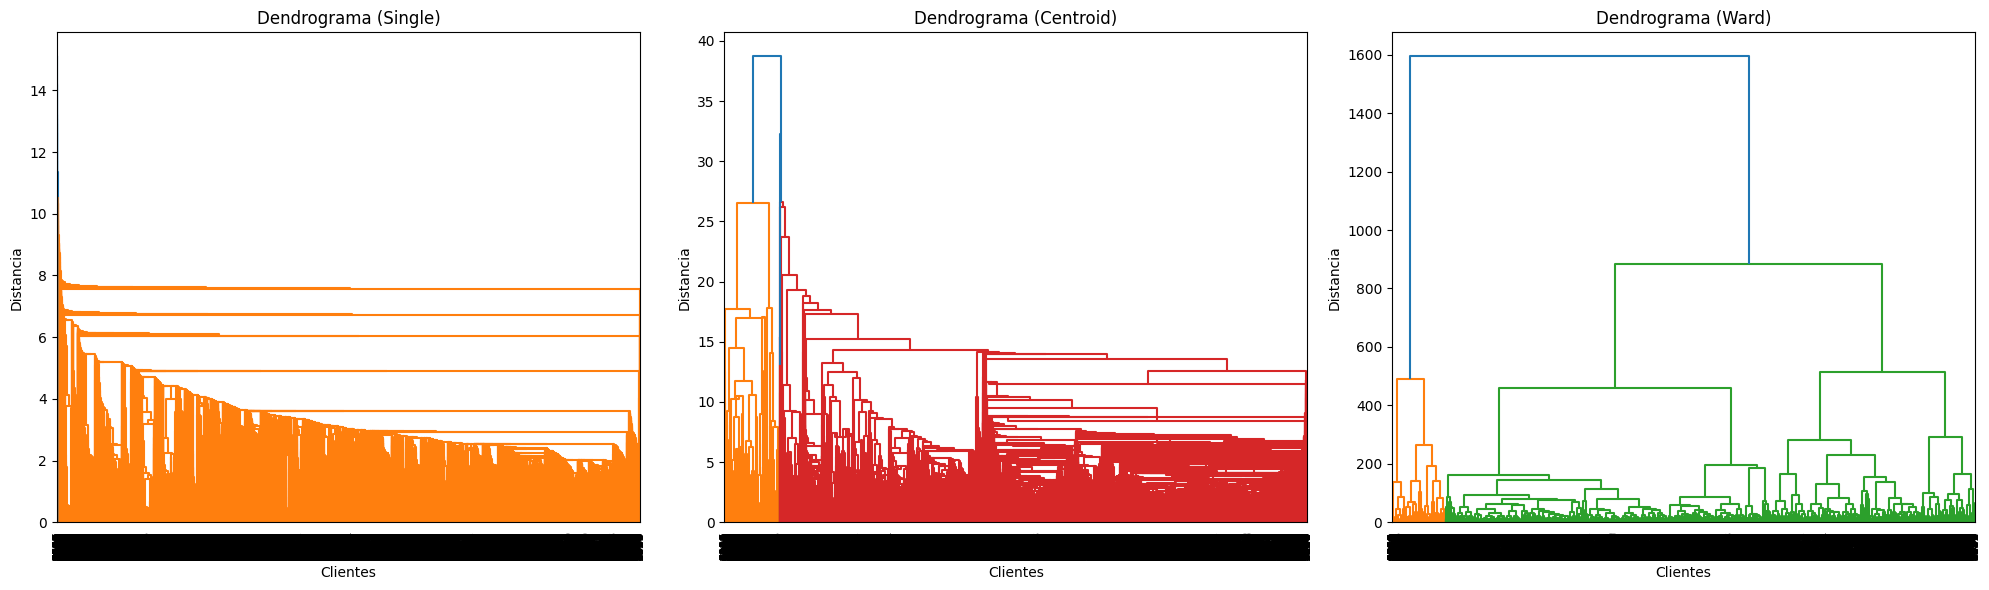

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=len(matrixes), figsize=(20, 6))

for i, matrix in enumerate(matrixes):
    axes[i].set_title(f'Dendrograma ({matrix})')
    axes[i].set_xlabel('Clientes')
    axes[i].set_ylabel('Distancia')
    dendrogram(matrixes[matrix], leaf_rotation=90., leaf_font_size=8., ax=axes[i])

plt.tight_layout()
plt.show()

In [7]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

cophenetSingle, _ = cophenet(distanceMatrixSingle, pdist(random_subset))
cophenetCentroid, _ = cophenet(distanceMatrixCentroid, pdist(random_subset))
cophenetWard, _ = cophenet(distanceMatrixWard, pdist(random_subset))

print('Coeficiente de correlación cofenético (single):', cophenetSingle)
print('Coeficiente de correlación cofenético (centroid):', cophenetCentroid)
print('Coeficiente de correlación cofenético (ward):', cophenetWard)

Coeficiente de correlación cofenético (single): 0.5447704591954444
Coeficiente de correlación cofenético (centroid): 0.9099020373522058
Coeficiente de correlación cofenético (ward): 0.8236333979962198


In [8]:
from scipy.cluster.hierarchy import fcluster

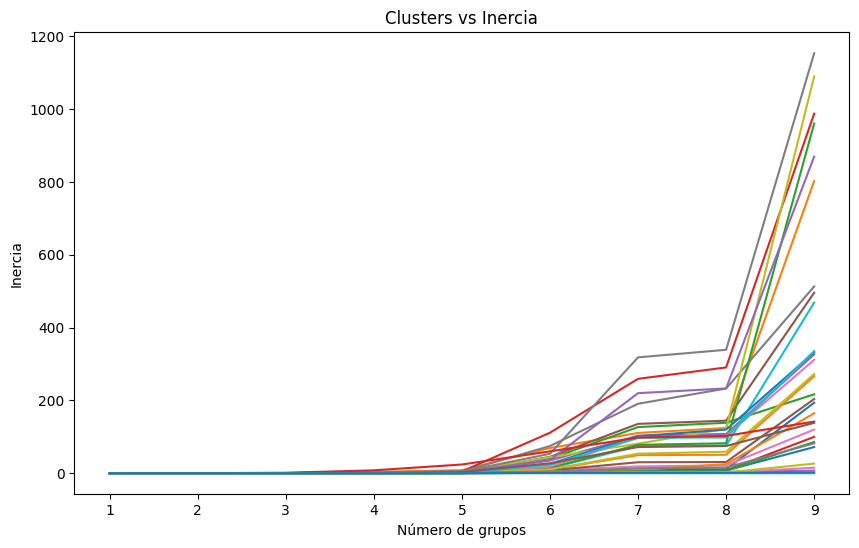

In [9]:
inertias = []

for i in range(1, 10):
    clusters = fcluster(distanceMatrixCentroid, t=i, criterion='distance')
    inertia = sum(
        np.sum(
            (
                random_subset[clusters == j]
                - np.mean(random_subset[clusters == j], axis=0)
            )
            ** 2
        )
        for j in range(1, i + 1)
    )
    inertias.append(inertia)

fig, ax = plt.subplots(figsize=(10, 6))

# Male
ax.plot(range(1, 10), inertias)
ax.set_xlabel('Número de grupos')
ax.set_ylabel('Inercia')
ax.set_title('Clusters vs Inercia')

plt.show()

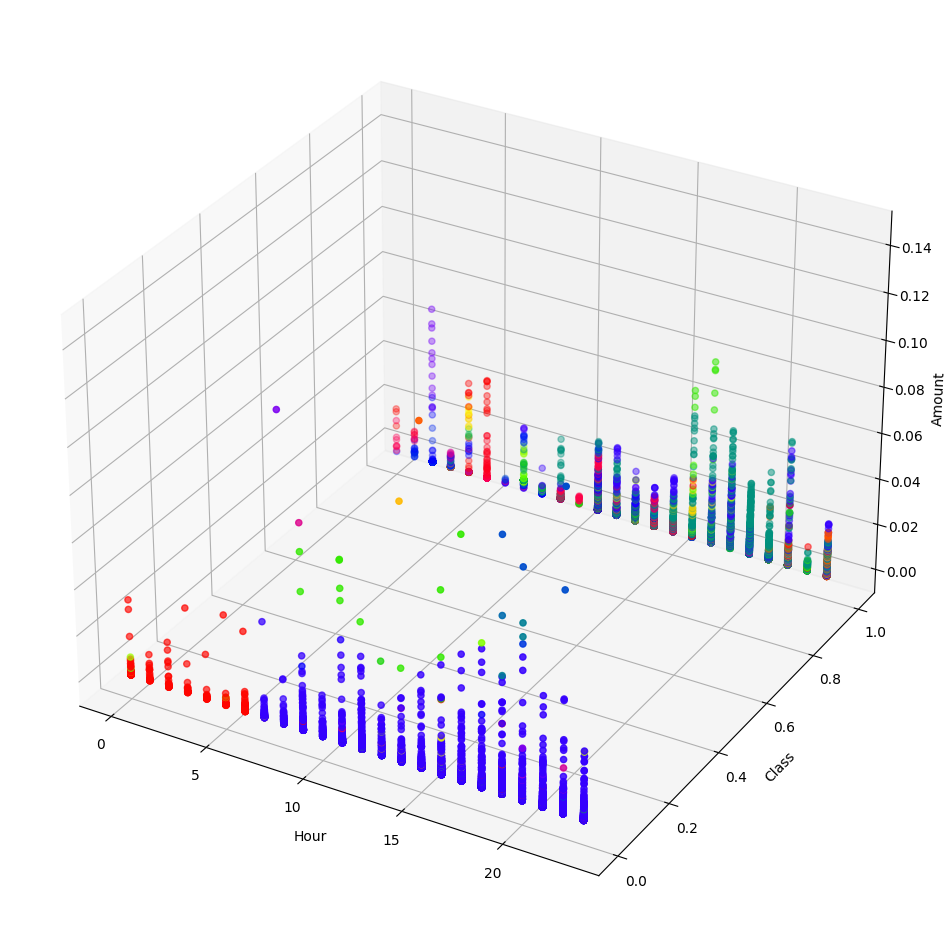

In [11]:
clusters: np.ndarray = fcluster(distanceMatrixCentroid, t=8, criterion='distance')
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(random_subset["Hour"], random_subset["Class"], random_subset["Amount"], c=clusters, cmap='prism')
ax.set_xlabel("Hour")
ax.set_ylabel("Class")
ax.set_zlabel("Amount")

plt.show()

#### DBSCAN with hyperparametrized values

In [14]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

FEATURES = preprocessed_data.drop('Class', axis=1).values
TARGET = preprocessed_data['Class'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(FEATURES)

eps_values = np.linspace(0.1, 5, 50)
min_samples_values = range(1, 20)

silhouette_scores, n_clusters, eps_list, min_samples_list = [], [], [], []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        n_clusters.append(len(set(labels)) - (1 if -1 in labels else 0))
        if -1 in labels:
            silhouette_scores.append(silhouette_score(X_scaled, labels))
        else:
            silhouette_scores.append(-1)
        eps_list.append(eps)
        min_samples_list.append(min_samples)

# Plot the results
plt.scatter(n_clusters, silhouette_scores, c=eps_list, cmap='viridis')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.colorbar(label='eps')
plt.title('DBSCAN Hyperparameter Tuning')
plt.show()